In [55]:
import statsmodels.api as sm
import patsy as pt
import pandas as pd
import numpy as np
import plotly.express as px
import statsmodels.tsa.stattools as st
from fbprophet import Prophet
from pygam import LinearGAM, s, f
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

orders = pd.read_csv("orders.csv")
order_items = pd.read_csv("order_items.csv")
order_reviews = pd.read_csv("order_reviews.csv")
order_payments = pd.read_csv("order_payments.csv")
products = pd.read_csv("products.csv")
product_category_name_translation = pd.read_csv('product_category_name_translation.csv')

# Merging data set

merge1 = pd.merge(order_items,order_reviews, on = ["order_id"])
merge1.to_csv("merge1.csv")

merge2 = pd.merge(merge1,order_payments, on = ["order_id"])
merge2.to_csv("merge2.csv")

merge3 = pd.merge(merge2,products, on = ["product_id"])
merge3.to_csv("merge3.csv")

merge4 = pd.merge(merge3,orders, on = ["order_id"])
merge4.to_csv("merge4.csv")


merge4['order_purchase_timestamp'] = pd.to_datetime(merge4['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
merge4['order_delivered_customer_date'] = pd.to_datetime(merge4['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
merge4['order_estimated_delivery_date'] = pd.to_datetime(merge4['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')

merge4['order_purchase_date'] = merge4.order_purchase_timestamp.dt.date
merge4['order_delivered_customer_date'] = merge4.order_delivered_customer_date.dt.date
merge4['order_estimated_delivery_date'] = merge4.order_estimated_delivery_date.dt.date



merge4['order_purchase_month'] = pd.to_datetime(merge4['order_purchase_timestamp']).dt.strftime('%Y-%m')
merge4['order_purchase_year'] = merge4.order_purchase_timestamp.dt.year


merge5 = pd.merge(merge4,product_category_name_translation, on = ["product_category_name"])
merge5.to_csv("merge5.csv")


# Selecting desired columns

data = merge5[['order_id', 'product_id', 'seller_id','order_purchase_month', 'order_purchase_year', 'order_item_id',
               'order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date',
               'order_purchase_date','order_delivered_customer_date','order_estimated_delivery_date', 'order_status',
               'price', 'payment_value','freight_value',
               'review_score', 'payment_type', 'payment_installments', 
               'product_category_name', 'product_description_lenght', 'product_photos_qty', 'product_category_name_english']].dropna()
data['category'] = data['product_category_name_english']

data = pd.DataFrame(data= data)

# Select rows if order_status = 'delivered'
data = data.loc[data['order_status'] == "delivered" ]

# Drop the data before January 2017 because the sales in November and december 2016 are 0 and 1 respectively

data = data.loc[data['order_purchase_year'] > 2016 ]
data['order_item_id']

0         1
1         1
2         1
3         1
4         1
         ..
116576    1
116577    1
116578    1
116579    1
116580    1
Name: order_item_id, Length: 113725, dtype: int64

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


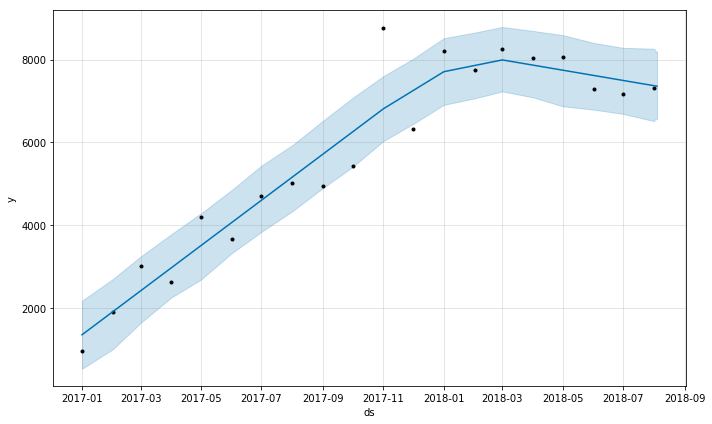

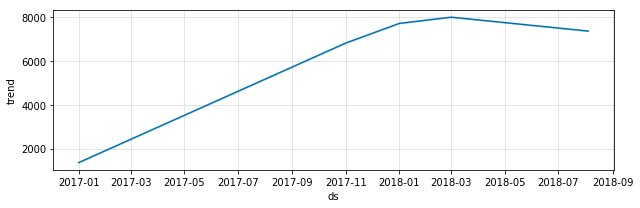

In [35]:
# Forecast sales next 3 months - by the monthly sales

data1 = data[['order_purchase_month','order_item_id']]
data1
# Getting the sales per month as the total number of items sold in a month
df = data1.groupby('order_purchase_month').count()
df['sales'] = df['order_item_id']
df['month'] = data['order_purchase_month'].unique()
df = df.drop(columns='order_item_id')
df['month'] = df.index
df = df[['month','sales']]


# Recreate the data frame with correct labels
data1 = pd.DataFrame(df.values, columns = ['ds','y'])
data1

# Initialize Prophet instance and fit to data

m = Prophet(changepoint_prior_scale=0.5)
# Higher prior values will tend toward overfitting
#     Lower values will tend toward underfitting

m.fit(data1)
# Create timeline for 1 year in future, 
#   then generate predictions based on that timeline

future = m.make_future_dataframe(periods=3)
forecast = m.predict(future)
forecast


# Create plots of forecast and truth, 
#   as well as component breakdowns of the trends

plt = m.plot(forecast)
plt.show()

comp = m.plot_components(forecast)
comp.show()

In [36]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,1365.590539,546.570070,2187.273313,1365.590539,1365.590539,0.0,0.0,0.0,0.0,0.0,0.0,1365.590539
1,2017-02-01,1920.984083,1015.004111,2707.731465,1920.984083,1920.984083,0.0,0.0,0.0,0.0,0.0,0.0,1920.984083
2,2017-03-01,2422.629869,1649.437752,3249.874947,2422.629869,2422.629869,0.0,0.0,0.0,0.0,0.0,0.0,2422.629869
3,2017-04-01,2978.023401,2262.162141,3788.744427,2978.023401,2978.023401,0.0,0.0,0.0,0.0,0.0,0.0,2978.023401
4,2017-05-01,3515.501019,2696.926308,4292.646311,3515.501019,3515.501019,0.0,0.0,0.0,0.0,0.0,0.0,3515.501019
5,2017-06-01,4070.894536,3330.724504,4854.305697,4070.894536,4070.894536,0.0,0.0,0.0,0.0,0.0,0.0,4070.894536
6,2017-07-01,4608.372131,3846.654586,5443.830245,4608.372131,4608.372131,0.0,0.0,0.0,0.0,0.0,0.0,4608.372131
7,2017-08-01,5163.765646,4340.656639,5933.230515,5163.765646,5163.765646,0.0,0.0,0.0,0.0,0.0,0.0,5163.765646
8,2017-09-01,5719.159171,4902.846223,6523.507780,5719.159171,5719.159171,0.0,0.0,0.0,0.0,0.0,0.0,5719.159171
9,2017-10-01,6256.636789,5411.145096,7077.443761,6256.636789,6256.636789,0.0,0.0,0.0,0.0,0.0,0.0,6256.636789


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-05,25.047099,-53.969463,117.139687,25.047099,25.047099,9.482073,9.482073,9.482073,9.482073,9.482073,9.482073,0.0,0.0,0.0,34.529172
1,2017-01-06,26.194392,-59.227932,106.444396,26.194392,26.194392,0.770689,0.770689,0.770689,0.770689,0.770689,0.770689,0.0,0.0,0.0,26.965081
2,2017-01-07,27.341684,-97.933306,68.764521,27.341684,27.341684,-45.726751,-45.726751,-45.726751,-45.726751,-45.726751,-45.726751,0.0,0.0,0.0,-18.385067
3,2017-01-08,28.488977,-90.087643,73.055132,28.488977,28.488977,-32.007626,-32.007626,-32.007626,-32.007626,-32.007626,-32.007626,0.0,0.0,0.0,-3.518650
4,2017-01-09,29.636269,-30.880952,134.740925,29.636269,29.636269,25.685046,25.685046,25.685046,25.685046,25.685046,25.685046,0.0,0.0,0.0,55.321315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,2018-11-28,203.104530,-6.042654,482.708256,-14.670337,451.394367,16.934550,16.934550,16.934550,16.934550,16.934550,16.934550,0.0,0.0,0.0,220.039080
693,2018-11-29,202.821187,-23.662459,472.244215,-19.209797,456.341519,9.482073,9.482073,9.482073,9.482073,9.482073,9.482073,0.0,0.0,0.0,212.303260
694,2018-11-30,202.537844,-30.774062,466.108542,-22.155440,458.934514,0.770689,0.770689,0.770689,0.770689,0.770689,0.770689,0.0,0.0,0.0,203.308533
695,2018-12-01,202.254501,-89.578127,420.706945,-25.052190,461.841243,-45.726751,-45.726751,-45.726751,-45.726751,-45.726751,-45.726751,0.0,0.0,0.0,156.527750


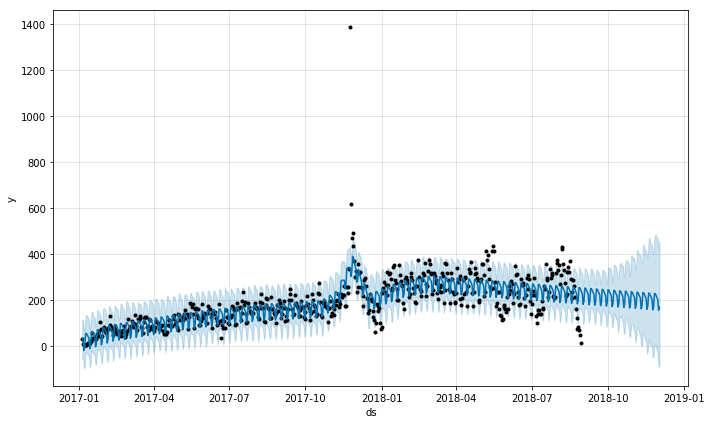

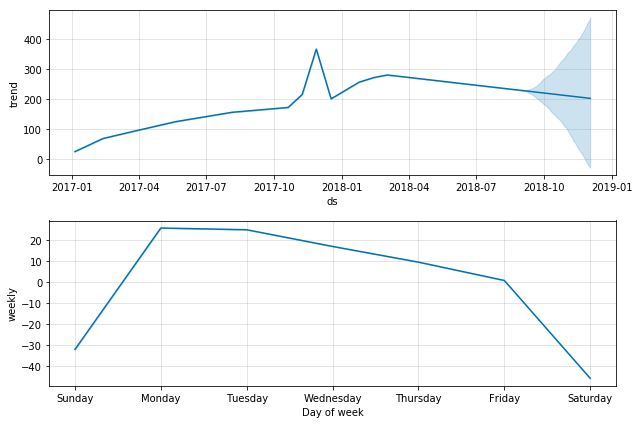

In [37]:
# Forecast sales next 3 months - by the daily sales

data2 = data[['order_purchase_date','order_item_id']]
data2
# Getting the sales per month as the total number of items sold in a month
df = data2.groupby('order_purchase_date').count()
df['sales'] = df['order_item_id']
df['date'] = data['order_purchase_date'].unique()
df = df.drop(columns='order_item_id')
df['date'] = df.index
df = df[['date','sales']]
df

# Recreate the data frame with correct labels
data1 = pd.DataFrame(df.values, columns = ['ds','y'])
data1

# Initialize Prophet instance and fit to data

m = Prophet(changepoint_prior_scale=0.5)
# Higher prior values will tend toward overfitting
#     Lower values will tend toward underfitting

m.fit(data1)
# Create timeline for 1 year in future, 
#   then generate predictions based on that timeline

future = m.make_future_dataframe(periods=95)
forecast = m.predict(future)
forecast

# Create plots of forecast and truth, 
#   as well as component breakdowns of the trends

plt = m.plot(forecast)
plt.show()

comp = m.plot_components(forecast)
comp.show()

forecast

In [38]:
# ARIMA model
# Plot the data
px.line(df, x='date', y='sales',
       labels = {
           'date' : 'Date',
           'sales' : 'Items sold per day'
       })

In [39]:
df['salesdiff'] = df['sales'].diff()
df
px.line(df, x='date', y='salesdiff',
       labels = {
           'date' : 'Date',
           'salesiff' : 'Differenced of sales'
       })

In [40]:
df['logsales'] = np.log(df['sales'])
df['logsalesdiff'] = df['logsales'].diff()
df
px.line(df, x='date', y='logsalesdiff',
       labels = {
           'date' : 'Date',
           'salesiff' : 'Differenced and logged of sales'
       })

In [41]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(df['sales'], (1,1,0)) 
		  # specifying an ARIMA(1,1,0) model
reg = model.fit() # Fit the model using standard params
res = reg.resid   # store the residuals as res
reg.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                  601
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3390.995
Method:                       css-mle   S.D. of innovations             68.257
Date:                Wed, 14 Oct 2020   AIC                           6787.990
Time:                        01:15:15   BIC                           6801.186
Sample:                    01-06-2017   HQIC                          6793.126
                         - 08-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0105      2.295     -0.005      0.996      -4.508       4.487
ar.L1.D.sales    -0.2136      0.040     -5.365      0.000      -0.292      -0.136
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.6811           +0.0000j            4.6811            0.5000
-----------------------------------------------------------------------------
"""

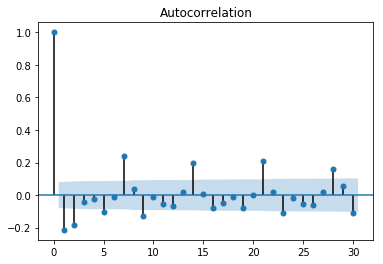

In [42]:
plt = sm.graphics.tsa.plot_acf(df['sales'].diff().dropna(), lags=30)
plt.show()

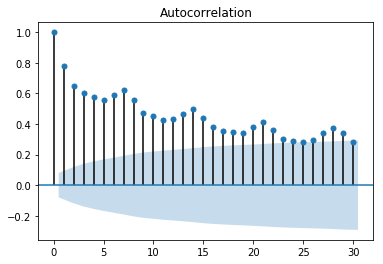

In [43]:
plt = sm.graphics.tsa.plot_acf(df['sales'], lags=30)
plt.show()

In [44]:
fcst = reg.forecast(steps=95)
fcst

(array([22.6095571 , 21.18481156, 21.47638559, 21.40131263, 21.40456426,
        21.39108387, 21.38117785, 21.37050825, 21.36000178, 21.34946045,
        21.33892657, 21.32839111, 21.31785598, 21.30732077, 21.29678559,
        21.2862504 , 21.27571521, 21.26518002, 21.25464483, 21.24410964,
        21.23357445, 21.22303926, 21.21250407, 21.20196888, 21.19143369,
        21.1808985 , 21.17036331, 21.15982812, 21.14929293, 21.13875774,
        21.12822256, 21.11768737, 21.10715218, 21.09661699, 21.0860818 ,
        21.07554661, 21.06501142, 21.05447623, 21.04394104, 21.03340585,
        21.02287066, 21.01233547, 21.00180028, 20.99126509, 20.9807299 ,
        20.97019471, 20.95965952, 20.94912433, 20.93858915, 20.92805396,
        20.91751877, 20.90698358, 20.89644839, 20.8859132 , 20.87537801,
        20.86484282, 20.85430763, 20.84377244, 20.83323725, 20.82270206,
        20.81216687, 20.80163168, 20.79109649, 20.7805613 , 20.77002611,
        20.75949093, 20.74895574, 20.73842055, 20.7

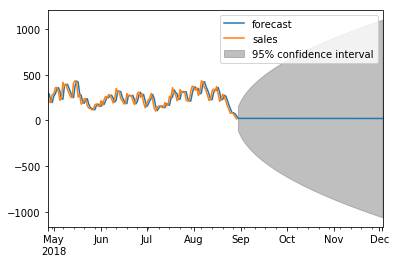

In [11]:
fig = reg.plot_predict(start=len(df)-125, end=len(df)+95)
fig.show()

In [12]:
df = data.groupby('category').count()
categories = df.sort_values(by = 'order_item_id', ascending = False)
categories['sales'] = categories['order_item_id']

##Sales dataframe

totalSales = pd.DataFrame(categories['sales'])

##total sales
totalSales

##visualizing total sales
fig = px.bar(totalSales, x= totalSales.index, y='sales')
fig.show()

###Best selling categories

best = totalSales.iloc[:3]
best

,sales
category,
bed_bath_table,11808
health_beauty,9772
sports_leisure,8774


In [45]:
categories

,order_id,product_id,seller_id,order_purchase_month,order_purchase_year,order_item_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date,...,payment_value,freight_value,review_score,payment_type,payment_installments,product_category_name,product_description_lenght,product_photos_qty,product_category_name_english,sales
category,,,,,,,,,,,,,,,,,,,,,
bed_bath_table,11808,11808,11808,11808,11808,11808,11808,11808,11808,11808,...,11808,11808,11808,11808,11808,11808,11808,11808,11808,11808
health_beauty,9772,9772,9772,9772,9772,9772,9772,9772,9772,9772,...,9772,9772,9772,9772,9772,9772,9772,9772,9772,9772
sports_leisure,8774,8774,8774,8774,8774,8774,8774,8774,8774,8774,...,8774,8774,8774,8774,8774,8774,8774,8774,8774,8774
furniture_decor,8566,8566,8566,8566,8566,8566,8566,8566,8566,8566,...,8566,8566,8566,8566,8566,8566,8566,8566,8566,8566
computers_accessories,7948,7948,7948,7948,7948,7948,7948,7948,7948,7948,...,7948,7948,7948,7948,7948,7948,7948,7948,7948,7948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
arts_and_craftmanship,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
la_cuisine,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
cds_dvds_musicals,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14


In [53]:
# Forecast sales next 3 months - for the 3 best selling

data2 = data[['order_purchase_date','order_item_id']]
data2
# Getting the sales per month as the total number of items sold in a month
df = data2.groupby('order_purchase_date').count()
# df['sales'] = df['order_item_id']
# df['date'] = data['order_purchase_date'].unique()
# df = df.drop(columns='order_item_id')
# df['date'] = df.index
# df = df[['date','sales']]
df

,order_item_id
order_purchase_date,
2017-01-05,32
2017-01-06,8
2017-01-07,5
2017-01-08,4
2017-01-09,6
...,...
2018-08-25,77
2018-08-26,84
2018-08-27,71


In [ ]:
# Forecast sales next 3 months - for the 3 best selling

data2 = data[['order_purchase_date','order_item_id']]
data2
# Getting the sales per month as the total number of items sold in a month
df = data2.groupby('order_purchase_date').count()
df['sales'] = df['order_item_id']
df['date'] = data['order_purchase_date'].unique()
df = df.drop(columns='order_item_id')
df['date'] = df.index
df = df[['date','sales']]
df

# Recreate the data frame with correct labels
data1 = pd.DataFrame(df.values, columns = ['ds','y'])
data1



In [13]:
top3bestSelling = categories.iloc[:3]
top3bestSelling

,order_id,product_id,seller_id,order_purchase_month,order_purchase_year,order_item_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date,...,payment_value,freight_value,review_score,payment_type,payment_installments,product_category_name,product_description_lenght,product_photos_qty,product_category_name_english,sales
category,,,,,,,,,,,,,,,,,,,,,
bed_bath_table,11808,11808,11808,11808,11808,11808,11808,11808,11808,11808,...,11808,11808,11808,11808,11808,11808,11808,11808,11808,11808
health_beauty,9772,9772,9772,9772,9772,9772,9772,9772,9772,9772,...,9772,9772,9772,9772,9772,9772,9772,9772,9772,9772
sports_leisure,8774,8774,8774,8774,8774,8774,8774,8774,8774,8774,...,8774,8774,8774,8774,8774,8774,8774,8774,8774,8774


In [14]:
categories

,order_id,product_id,seller_id,order_purchase_month,order_purchase_year,order_item_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date,...,payment_value,freight_value,review_score,payment_type,payment_installments,product_category_name,product_description_lenght,product_photos_qty,product_category_name_english,sales
category,,,,,,,,,,,,,,,,,,,,,
bed_bath_table,11808,11808,11808,11808,11808,11808,11808,11808,11808,11808,...,11808,11808,11808,11808,11808,11808,11808,11808,11808,11808
health_beauty,9772,9772,9772,9772,9772,9772,9772,9772,9772,9772,...,9772,9772,9772,9772,9772,9772,9772,9772,9772,9772
sports_leisure,8774,8774,8774,8774,8774,8774,8774,8774,8774,8774,...,8774,8774,8774,8774,8774,8774,8774,8774,8774,8774
furniture_decor,8566,8566,8566,8566,8566,8566,8566,8566,8566,8566,...,8566,8566,8566,8566,8566,8566,8566,8566,8566,8566
computers_accessories,7948,7948,7948,7948,7948,7948,7948,7948,7948,7948,...,7948,7948,7948,7948,7948,7948,7948,7948,7948,7948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
arts_and_craftmanship,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
la_cuisine,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
cds_dvds_musicals,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14


In [15]:
#Determine the three best-selling categories, and create a forecast of growth in those categories


In [16]:
#Determine the fastest-growing category, and create a forecast for its growth
data3 = data[['order_purchase_date','category', 'order_item_id']]

#data2['year'] = pd.DatetimeIndex(data2['order_purchase_date']).year
#data2['month'] = pd.DatetimeIndex(data2['order_purchase_date']).month
data3['date'] = pd.to_datetime(data['order_purchase_timestamp'])

catSales = data3.set_index('date').groupby([pd.Grouper(freq='M'), 'category']).count()
sales = pd.DataFrame(catSales)
sales['count'] = sales['order_item_id']
# sales_categorized = sales
# sales_categorized = sales_categorized.drop(columns= ['order_purchase_date', 'order_item_id'])
# sales_categorized
sales = sales.drop(columns = 'order_purchase_date')
sales1 = sales.reset_index()
sales1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,category,order_item_id,count
0,2017-01-31,agro_industry_and_commerce,3,3
1,2017-01-31,air_conditioning,4,4
2,2017-01-31,auto,31,31
3,2017-01-31,baby,40,40
4,2017-01-31,bed_bath_table,49,49
...,...,...,...,...
1207,2018-08-31,sports_leisure,477,477
1208,2018-08-31,stationery,171,171
1209,2018-08-31,telephony,283,283
1210,2018-08-31,toys,165,165


In [66]:
# Create data frame of sales of each category each day

sales1["date"] = pd.to_datetime(sales1["date"])
sales2 = sales1.set_index(pd.DatetimeIndex(sales1['date']))
sales2
category = sales2['category'].unique()
date = sales2.index.unique()
test = pd.DataFrame(columns = category.T,
                    index = date)
test

for i in test.columns:
    test[i] = sales2[sales2['category'] == str(i)]['count']

df3 = test.fillna(0)    
df3 # data frame of sales of each category each day

# Calculate the percentage change of sales 
data_pct = df3.pct_change()
newdata = pd.DataFrame(data_pct)
newdata = newdata.replace([np.inf, -np.inf], np.nan)
newdata1 = newdata.fillna(0)
newdata1  # data frame of percantage change of sales of each category each day



,agro_industry_and_commerce,air_conditioning,auto,baby,bed_bath_table,books_general_interest,computers,computers_accessories,consoles_games,cool_stuff,...,furniture_mattress_and_upholstery,la_cuisine,arts_and_craftmanship,fashion_childrens_clothes,small_appliances_home_oven_and_coffee,cds_dvds_musicals,construction_tools_lights,party_supplies,flowers,diapers_and_hygiene
date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-02-28,2.000000,2.000000,1.774194,-0.200000,2.510204,3.000000,0.000000,2.225806,-0.142857,0.921053,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-03-31,-0.777778,0.500000,-0.081395,0.437500,0.819767,2.000000,-1.000000,0.720000,1.833333,0.780822,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-04-30,-1.000000,-0.166667,0.177215,0.108696,-0.012780,-0.500000,0.000000,-0.209302,-0.666667,-0.053846,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-05-31,0.000000,-0.533333,0.301075,1.117647,0.362460,0.666667,0.000000,1.389706,0.882353,1.138211,...,4.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-06-30,-0.750000,0.571429,-0.041322,-0.268519,0.002375,0.000000,0.000000,-0.181538,-0.062500,-0.193916,...,-1.000000,-1.000000,-1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-07-31,0.000000,-0.545455,0.043103,0.708861,0.488152,-0.350000,0.000000,0.293233,0.700000,0.169811,...,0.000000,0.000000,0.000000,-1.0,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-08-31,3.000000,2.200000,0.421488,-0.044444,-0.070064,1.153846,0.000000,0.066860,0.725490,0.080645,...,1.000000,-0.666667,-1.000000,0.0,0.000000,-0.400000,1.000000,-1.000000,0.000000,0.000000
2017-09-30,0.000000,-0.562500,-0.360465,0.364341,-0.025685,-0.464286,0.689655,-0.283379,-0.250000,-0.216418,...,-0.500000,-1.000000,0.000000,0.0,0.000000,-1.000000,-0.500000,0.000000,0.000000,0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-31,0.680855,-0.002436,1.410418,0.680855,0.680855,0.0,0.0,0.0,0.0,0.0,0.0,0.680855
1,2017-02-28,0.637323,-0.076003,1.282191,0.637323,0.637323,0.0,0.0,0.0,0.0,0.0,0.0,0.637323
2,2017-03-31,0.589127,-0.113780,1.264895,0.589127,0.589127,0.0,0.0,0.0,0.0,0.0,0.0,0.589127
3,2017-04-30,0.542485,-0.189238,1.205941,0.542485,0.542485,0.0,0.0,0.0,0.0,0.0,0.0,0.542485
4,2017-05-31,0.494289,-0.200181,1.173308,0.494289,0.494289,0.0,0.0,0.0,0.0,0.0,0.0,0.494289
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,2018-11-30,-0.350806,-1.061076,0.334738,-0.350931,-0.350688,0.0,0.0,0.0,0.0,0.0,0.0,-0.350806
111,2018-12-01,-0.352345,-1.046591,0.314607,-0.352474,-0.352226,0.0,0.0,0.0,0.0,0.0,0.0,-0.352345
112,2018-12-02,-0.353884,-1.094256,0.349849,-0.354016,-0.353764,0.0,0.0,0.0,0.0,0.0,0.0,-0.353884
113,2018-12-03,-0.355424,-1.076403,0.336517,-0.355558,-0.355301,0.0,0.0,0.0,0.0,0.0,0.0,-0.355424


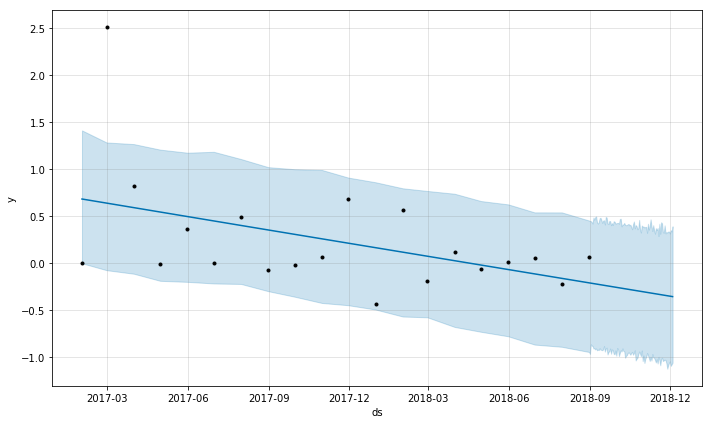

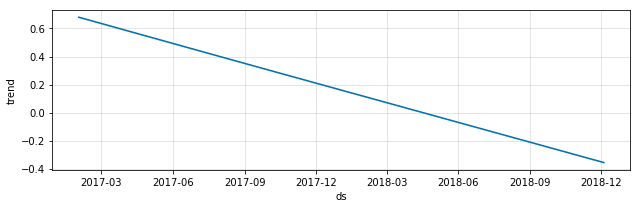

In [79]:
# Forecast the growth in the 3 best selling categories
growth_bestselling = newdata1[['bed_bath_table', 'health_beauty', 'sports_leisure']]

growth_bestselling.reset_index('date')
growth_bestselling['date']= growth_bestselling.index
growth_bestselling1 = growth_bestselling[['date', 'bed_bath_table']]

# Recreate the data frame with correct labels
data1 = pd.DataFrame(growth_bestselling1.values, columns = ['ds','y'])
data1

# Initialize Prophet instance and fit to data

m = Prophet(changepoint_prior_scale=0.5)
# Higher prior values will tend toward overfitting
#     Lower values will tend toward underfitting

m.fit(data1)
# Create timeline for 1 year in future, 
#   then generate predictions based on that timeline

future = m.make_future_dataframe(periods=95)
forecast = m.predict(future)
forecast

# Create plots of forecast and truth, 
#   as well as component breakdowns of the trends

plt = m.plot(forecast)
plt.show()

comp = m.plot_components(forecast)
comp.show()

forecast

In [ ]:
# Calculate avarage growth rate of sales of each category each day
avg_growthRate = newdata1.mean()
avg_growthRate = pd.DataFrame(avg_growthRate)
avg_growthRate.columns = ['Average Growth Rate']
avg_growthRate1 = avg_growthRate.sort_values(by = 'Average Growth Rate', ascending = False)
avg_growthRate1

# Select top 5 highest avarage growth rates
top5_Average_GrowthRate = avg_growthRate1.iloc[:5]
top5_Average_GrowthRate

In [70]:
top5_Average_GrowthRate = newdata1[['signaling_and_security', 'food','air_conditioning', 
                                   'home_construction', 'musical_instruments']]
top5_Average_GrowthRate.reset_index('date')
top5_Average_GrowthRate['date']= top5_Average_GrowthRate.index
top5_Average_GrowthRate

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,signaling_and_security,food,air_conditioning,home_construction,musical_instruments,date
date,,,,,,
2017-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,2017-01-31
2017-02-28,0.000000,3.500000,2.000000,0.000000,9.000000,2017-02-28
2017-03-31,0.000000,1.444444,0.500000,1.750000,0.000000,2017-03-31
2017-04-30,2.000000,-0.590909,-0.166667,-0.545455,0.600000,2017-04-30
2017-05-31,0.333333,-0.666667,-0.533333,0.400000,1.312500,2017-05-31
2017-06-30,-0.750000,-0.666667,0.571429,0.142857,-0.459459,2017-06-30
2017-07-31,4.000000,6.000000,-0.545455,-0.750000,0.700000,2017-07-31
2017-08-31,-0.200000,1.000000,2.200000,-0.500000,-0.323529,2017-08-31
2017-09-30,1.250000,0.214286,-0.562500,10.000000,0.217391,2017-09-30


In [71]:
# Plot the data
px.line(top5_Average_GrowthRate, x='date',y = ['signaling_and_security','food','air_conditioning', 
                                   'home_construction', 'musical_instruments'],
       labels = {
           'date' : 'Date',
           'sales' : 'Items sold per day'
       })

In [21]:
newdata1['fashion_bags_accessories']

date
2017-01-31    0.000000
2017-02-28    0.000000
2017-03-31    0.868421
2017-04-30   -0.295775
2017-05-31    1.340000
2017-06-30   -0.264957
2017-07-31    0.081395
2017-08-31    0.107527
2017-09-30    0.281553
2017-10-31   -0.151515
2017-11-30    0.901786
2017-12-31   -0.300469
2018-01-31   -0.114094
2018-02-28   -0.159091
2018-03-31    0.270270
2018-04-30   -0.234043
2018-05-31    0.120370
2018-06-30   -0.223140
2018-07-31   -0.180851
2018-08-31    0.675325
Name: fashion_bags_accessories, dtype: float64

In [22]:
# Calculate median growth rate of sales of each category each day

median_growthRate = newdata1.median()
median_growthRate = pd.DataFrame(median_growthRate)
median_growthRate.columns = ['Median Growth Rate']
median_growthRate1 = median_growthRate.sort_values(by = 'Median Growth Rate', ascending = False)

# Slect top 5 highest median growth rates
top_Median_GrowthRate = median_growthRate1.iloc[:5]
top_Median_GrowthRate

,Median Growth Rate
watches_gifts,0.205114
luggage_accessories,0.193750
pet_shop,0.150222
food,0.121429
air_conditioning,0.102381


In [23]:
newdata1['luggage_accessories']

date
2017-01-31    0.000000
2017-02-28    4.600000
2017-03-31    0.428571
2017-04-30    0.250000
2017-05-31    0.460000
2017-06-30   -0.136986
2017-07-31    0.349206
2017-08-31   -0.235294
2017-09-30   -0.261538
2017-10-31    0.250000
2017-11-30    0.200000
2017-12-31   -0.361111
2018-01-31    1.913043
2018-02-28   -0.641791
2018-03-31    0.187500
2018-04-30    0.105263
2018-05-31   -0.190476
2018-06-30   -0.235294
2018-07-31    0.410256
2018-08-31    0.200000
Name: luggage_accessories, dtype: float64

In [24]:
top5_Median_GrowthRate = newdata1[['watches_gifts', 'luggage_accessories','pet_shop', 
                                   'food', 'air_conditioning']]
top5_Median_GrowthRate.reset_index('date')
top5_Median_GrowthRate['date']= top5_Average_GrowthRate.index
top5_Median_GrowthRate

# Plot the data
px.line(top5_Median_GrowthRate, x='date',y = ['watches_gifts', 'luggage_accessories','pet_shop', 
                                   'food', 'air_conditioning'],
       labels = {
           'date' : 'Date',
           'sales' : 'Items sold per day'
       })

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
## Create a forecast for top 5 median growth rate
top5_Median_GrowthRate = top5_Median_GrowthRate[['date','watches_gifts', 'luggage_accessories', 'pet_shop', 'food',
       'air_conditioning']]
top5_Median_GrowthRate 

,date,watches_gifts,luggage_accessories,pet_shop,food,air_conditioning
date,,,,,,
2017-01-31,2017-01-31,0.000000,0.000000,0.000000,0.000000,0.000000
2017-02-28,2017-02-28,2.181818,4.600000,1.928571,3.500000,2.000000
2017-03-31,2017-03-31,1.285714,0.428571,0.073171,1.444444,0.500000
2017-04-30,2017-04-30,0.300000,0.250000,0.227273,-0.590909,-0.166667
2017-05-31,2017-05-31,0.307692,0.460000,0.388889,-0.666667,-0.533333
2017-06-30,2017-06-30,-0.080882,-0.136986,-0.040000,-0.666667,0.571429
2017-07-31,2017-07-31,0.368000,0.349206,0.236111,6.000000,-0.545455
2017-08-31,2017-08-31,0.263158,-0.235294,0.022472,1.000000,2.200000
2017-09-30,2017-09-30,0.282407,-0.261538,-0.175824,0.214286,-0.562500


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-31,0.756048,0.178928,1.374843,0.756048,0.756048,0.0,0.0,0.0,0.0,0.0,0.0,0.756048
1,2017-02-28,0.709571,0.141925,1.298502,0.709571,0.709571,0.0,0.0,0.0,0.0,0.0,0.0,0.709571
2,2017-03-31,0.658115,0.081770,1.227361,0.658115,0.658115,0.0,0.0,0.0,0.0,0.0,0.0,0.658115
3,2017-04-30,0.608319,0.028969,1.167268,0.608319,0.608319,0.0,0.0,0.0,0.0,0.0,0.0,0.608319
4,2017-05-31,0.556863,-0.027385,1.138173,0.556863,0.556863,0.0,0.0,0.0,0.0,0.0,0.0,0.556863
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,2018-11-30,-0.348066,-0.887784,0.225713,-0.348150,-0.347957,0.0,0.0,0.0,0.0,0.0,0.0,-0.348066
111,2018-12-01,-0.349714,-0.910596,0.278330,-0.349799,-0.349604,0.0,0.0,0.0,0.0,0.0,0.0,-0.349714
112,2018-12-02,-0.351363,-0.958418,0.211345,-0.351449,-0.351251,0.0,0.0,0.0,0.0,0.0,0.0,-0.351363
113,2018-12-03,-0.353011,-0.947580,0.194529,-0.353099,-0.352898,0.0,0.0,0.0,0.0,0.0,0.0,-0.353011


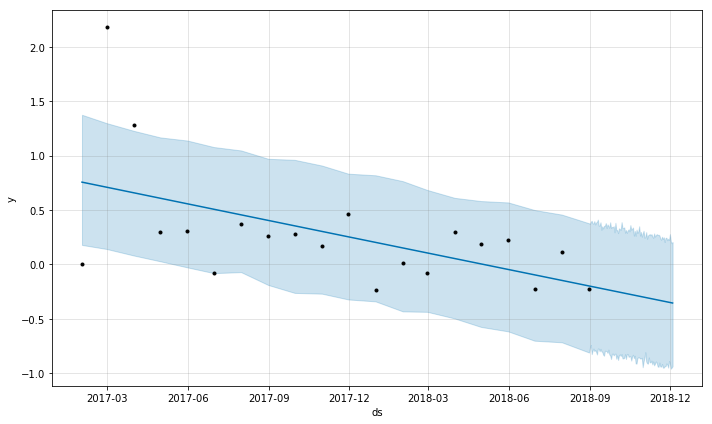

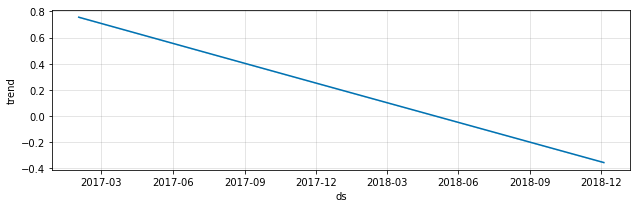

In [26]:
gr1 = top5_Median_GrowthRate [['date','watches_gifts']]
gr1

# Recreate the data frame with correct labels
data1 = pd.DataFrame(gr1.values, columns = ['ds','y'])
data1

# Initialize Prophet instance and fit to data

m = Prophet(changepoint_prior_scale=0.5)
# Higher prior values will tend toward overfitting
#     Lower values will tend toward underfitting

m.fit(data1)
# Create timeline for 1 year in future, 
#   then generate predictions based on that timeline

future = m.make_future_dataframe(periods=95)
forecast = m.predict(future)
forecast

# Create plots of forecast and truth, 
#   as well as component breakdowns of the trends

plt = m.plot(forecast)
plt.show()

comp = m.plot_components(forecast)
comp.show()

forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-31,0.756048,0.164215,1.342752,0.756048,0.756048,0.0,0.0,0.0,0.0,0.0,0.0,0.756048
1,2017-02-28,0.709571,0.121785,1.271588,0.709571,0.709571,0.0,0.0,0.0,0.0,0.0,0.0,0.709571
2,2017-03-31,0.658115,0.070042,1.210590,0.658115,0.658115,0.0,0.0,0.0,0.0,0.0,0.0,0.658115
3,2017-04-30,0.608319,0.054717,1.200677,0.608319,0.608319,0.0,0.0,0.0,0.0,0.0,0.0,0.608319
4,2017-05-31,0.556863,-0.052719,1.149063,0.556863,0.556863,0.0,0.0,0.0,0.0,0.0,0.0,0.556863
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,2018-11-30,-0.348066,-0.912592,0.240641,-0.348157,-0.347968,0.0,0.0,0.0,0.0,0.0,0.0,-0.348066
111,2018-12-01,-0.349714,-0.949066,0.240924,-0.349807,-0.349615,0.0,0.0,0.0,0.0,0.0,0.0,-0.349714
112,2018-12-02,-0.351363,-0.919159,0.217840,-0.351458,-0.351263,0.0,0.0,0.0,0.0,0.0,0.0,-0.351363
113,2018-12-03,-0.353011,-1.016544,0.213486,-0.353108,-0.352910,0.0,0.0,0.0,0.0,0.0,0.0,-0.353011


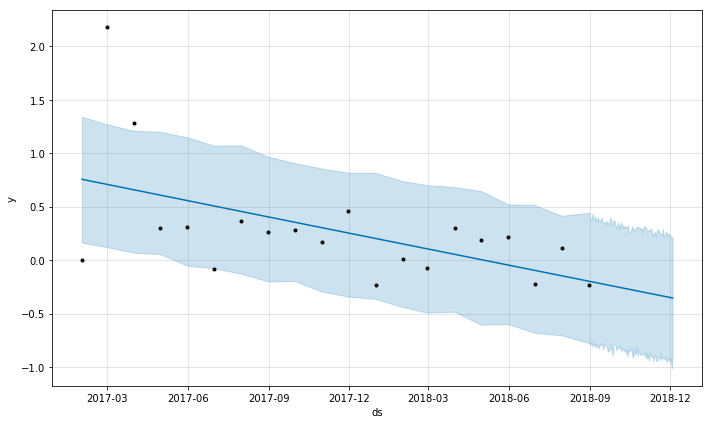

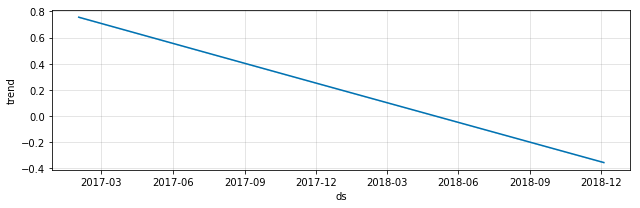

In [27]:
gr2 = top5_Median_GrowthRate [['date','luggage_accessories',]]
gr2

# Recreate the data frame with correct labels
data1 = pd.DataFrame(gr1.values, columns = ['ds','y'])
data1

# Initialize Prophet instance and fit to data

m = Prophet(changepoint_prior_scale=0.5)
# Higher prior values will tend toward overfitting
#     Lower values will tend toward underfitting

m.fit(data1)
# Create timeline for 1 year in future, 
#   then generate predictions based on that timeline

future = m.make_future_dataframe(periods=95)
forecast = m.predict(future)
forecast

# Create plots of forecast and truth, 
#   as well as component breakdowns of the trends

plt = m.plot(forecast)
plt.show()

comp = m.plot_components(forecast)
comp.show()

forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-31,0.756048,0.146760,1.342821,0.756048,0.756048,0.0,0.0,0.0,0.0,0.0,0.0,0.756048
1,2017-02-28,0.709571,0.128841,1.312552,0.709571,0.709571,0.0,0.0,0.0,0.0,0.0,0.0,0.709571
2,2017-03-31,0.658115,0.052569,1.238815,0.658115,0.658115,0.0,0.0,0.0,0.0,0.0,0.0,0.658115
3,2017-04-30,0.608319,0.004244,1.210063,0.608319,0.608319,0.0,0.0,0.0,0.0,0.0,0.0,0.608319
4,2017-05-31,0.556863,-0.016312,1.164682,0.556863,0.556863,0.0,0.0,0.0,0.0,0.0,0.0,0.556863
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,2018-11-30,-0.348066,-0.955890,0.211316,-0.348172,-0.347962,0.0,0.0,0.0,0.0,0.0,0.0,-0.348066
111,2018-12-01,-0.349714,-0.976711,0.269934,-0.349822,-0.349609,0.0,0.0,0.0,0.0,0.0,0.0,-0.349714
112,2018-12-02,-0.351363,-0.946950,0.250297,-0.351472,-0.351256,0.0,0.0,0.0,0.0,0.0,0.0,-0.351363
113,2018-12-03,-0.353011,-0.947519,0.223496,-0.353123,-0.352903,0.0,0.0,0.0,0.0,0.0,0.0,-0.353011


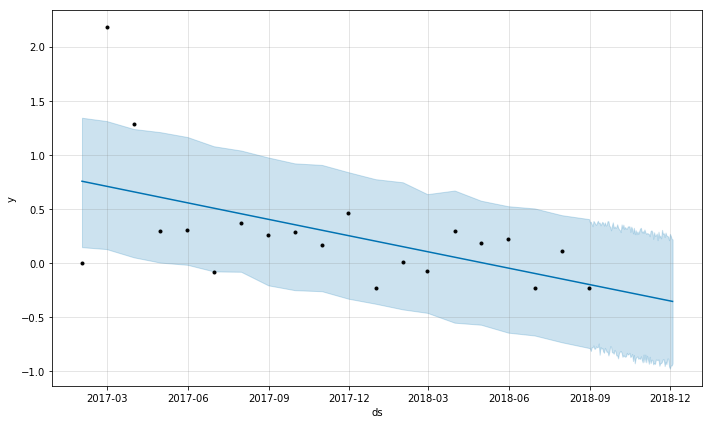

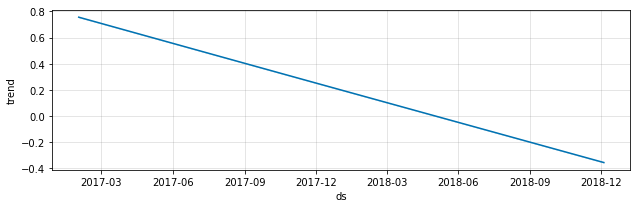

In [28]:
gr2 = top5_Median_GrowthRate [['date','food']]
gr2

# Recreate the data frame with correct labels
data1 = pd.DataFrame(gr1.values, columns = ['ds','y'])
data1

# Initialize Prophet instance and fit to data

m = Prophet(changepoint_prior_scale=0.5)
# Higher prior values will tend toward overfitting
#     Lower values will tend toward underfitting

m.fit(data1)
# Create timeline for 1 year in future, 
#   then generate predictions based on that timeline

future = m.make_future_dataframe(periods=95)
forecast = m.predict(future)
forecast

# Create plots of forecast and truth, 
#   as well as component breakdowns of the trends

plt = m.plot(forecast)
plt.show()

comp = m.plot_components(forecast)
comp.show()

forecast